<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapitel 5: Featureauswahl

Im letzten Kapitel hast du bereits Einsichten in Lernstrategien bekommen und mehrere unserer Beispiele nachvollzogen. Jetzt wollen
wir uns zusammen weitere Details ansehen und dein Verständnis vertiefen. Was sind die wichtigen Eigenschaften der Daten? Was
hängt womit zusammen? Auch etwas statistisches Wissen kommt hier hinzu.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import sklearn
print(sklearn.__version__)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


1.1.1


In [6]:
import numpy as np
print(np.__version__)

1.22.4


In [7]:
import matplotlib.pyplot as plt

## Reduzierung der Features

Am Anfang eines Projekts stehst du manchmal vor einem Haufen Daten mit sehr vielen Attributen pro Datensatz. Alle diese Attribute sind potenzielle Features, allerdings weißt du noch nicht, ob alle wirklich nützlich sind. Da man mit Sklearn relativ einfach mit multidimensionalen Daten arbeiten kann, könnte man beschließen, einfach alle Attribute als Feature-Input für einen Machine-Learning-Algorithmus zu benutzen.
Es gibt allerdings drei gute Gründe, warum eine Auswahl bzw. Reduzierung der Features häufig sinnvoll ist:

1. Vermeidung von Overfitting bei komplexen Modellen: Die Anwendung vieler Features bedeutet eine Optimierung in einem Feature-Raum mit sehr hoher Dimension. Je größer die Dimensionalität, desto mehr Daten braucht man, um statistisch signifikante Aussagen machen zu können. Overfitting entsteht häufig, wenn du zu wenige Daten hast oder die Dimension deines Feature-Raums zu hoch gewählt hast.
2. Reduzierung der Trainingszeit: Neben der Größe des Datensatzes, dem verwendeten Algorithmus und den verfügbaren Rechenressourcen hängen die Trainingszeiten auch von der Anzahl der Features ab.
3. Bessere Interpretierbarkeit der Daten: Je mehr Features du benutzt, desto schwieriger wird es, mögliche Kausalitäten abzuleiten. Diese könnten dir bei manchen Problemen helfen, die richtigen Maßnahmen zu empfehlen – etwa wenn du mögliche Faktoren für eine bestimmte Krebserkrankung identifizieren möchtest.

## Fluch der hohen Dimensionen

Punkt 1 wird oft auch als Fluch der hohen Dimensionen bezeichnet. Zur Illustration generieren wir mithilfe des Zufallsgenerators von NumPy drei Features: $x_1$, $x_2$ und $x_3$. Sie werden dabei unabhängig voneinander so generiert, dass sie gleichförmig im Bereich zwischen 0 und 10 liegen:

In [8]:
# Erzeuge jeweils 3 Features mit 100 Beispielen, gleichverteilt zwischen 0 und 10
n = 100
vmin, vmax = 0, 10

x1 =  np.random.uniform(vmin, vmax, n)
x2 =  np.random.uniform(vmin, vmax, n)
x3 =  np.random.uniform(vmin, vmax, n)

In [7]:
# plt.hist?

In Abbildung 5-1 ist die eindimensionale Verteilung von $x_1$ als Histogramm dargestellt. Wir haben nun Bins, die jeweils einen Wertebereich zusammenfassen. Du kannst erkennen, dass ein Bin der Länge 1 im Durchschnitt etwa 10 Beispiele enthält, wenn wir 100
Beispiele generieren.

Text(0, 0.5, 'n samples')

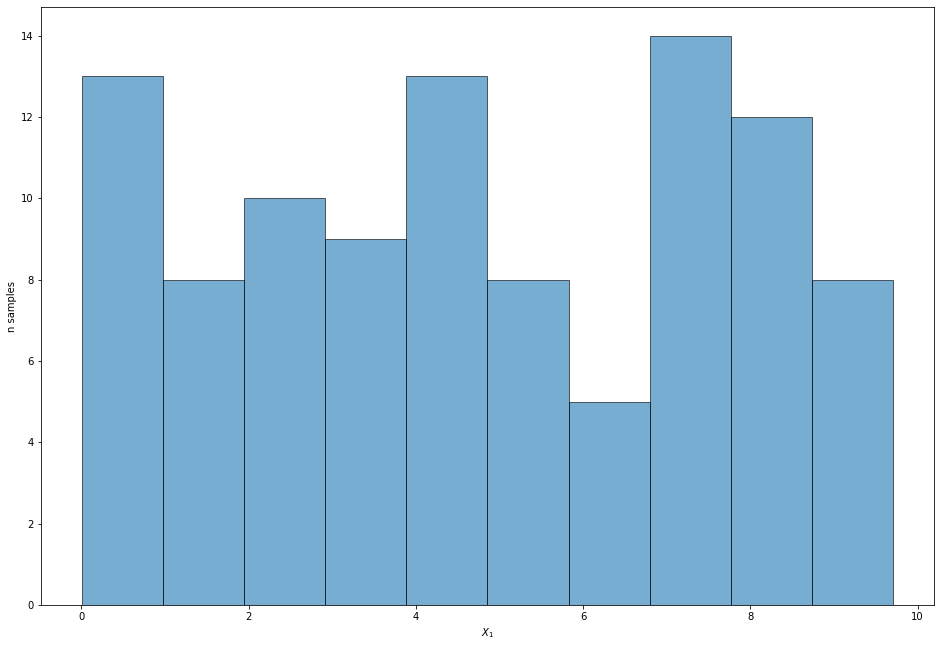

In [9]:
# Visualisiere die Verteilung von x_1

fig = plt.figure(figsize=(16, 11))

plt.hist(x1, alpha=0.6, edgecolor='black', lw=1, bins=10)

plt.xlabel('$X_1$')
plt.ylabel('n samples')

# fig.savefig('ML_0512.png', bbox_inches='tight')

Nun erhöhen wir schrittweise die Dimension und sehen, wie sich das auf die Verteilung auswirkt. Die zweidimensionale Verteilung
von $x_1$ und $x_2$ in Abbildung 5-2 zeigt schon eine deutliche »Verdünnung« der Beispiele pro Quadrat mit der Kantenlänge 1. Statistisch
erwarten wir im Durchschnitt ein Beispiel pro Box.

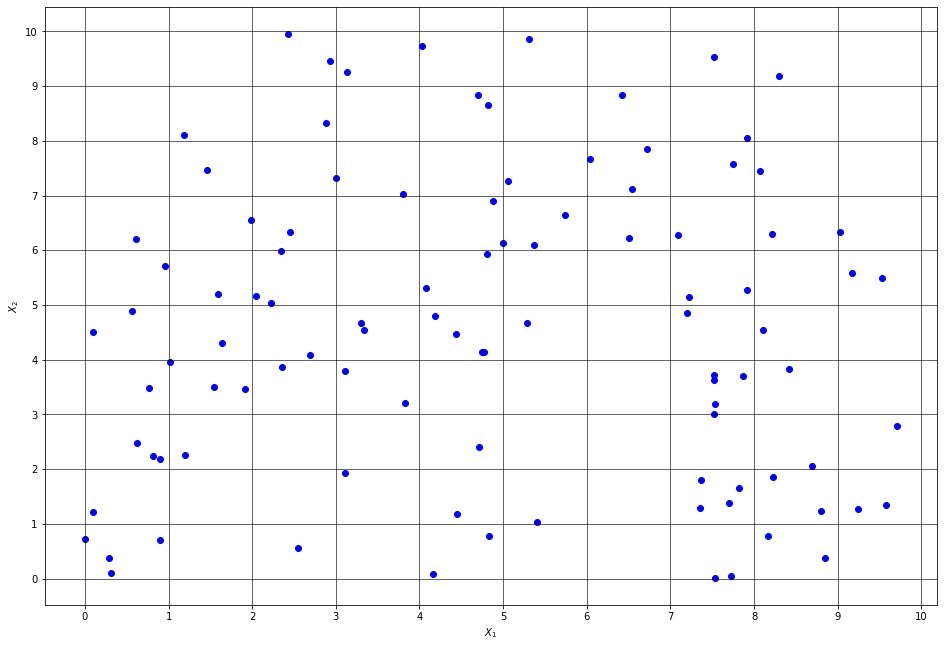

In [10]:
# Visualisiere die Verteilung von x_1 und x_2

fig = plt.figure(figsize=(16, 11))

plt.scatter(x1, x2, c="b", marker="o")

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.xticks(np.arange(0, 11, 1) )
plt.yticks(np.arange(0, 11, 1) )
plt.grid(color='k', linestyle='-', linewidth=1, alpha=0.6)

# fig.savefig('ML_0513.png', bbox_inches='tight')

Bei der dreidimensionalen Verteilung von $x_1$, $x_2$, $x_3$ in Abbildung 5-3 erwarten wir nur noch 0,1 Beispiele pro Kubus mit der Kantenlänge 1. Das heißt, je mehr Features du benutzt, desto weniger Daten pro Einheitsbox im Feature-Raum hast du im Durchschnitt zur Verfügung.

Text(0.5, 0, '$X_3$')

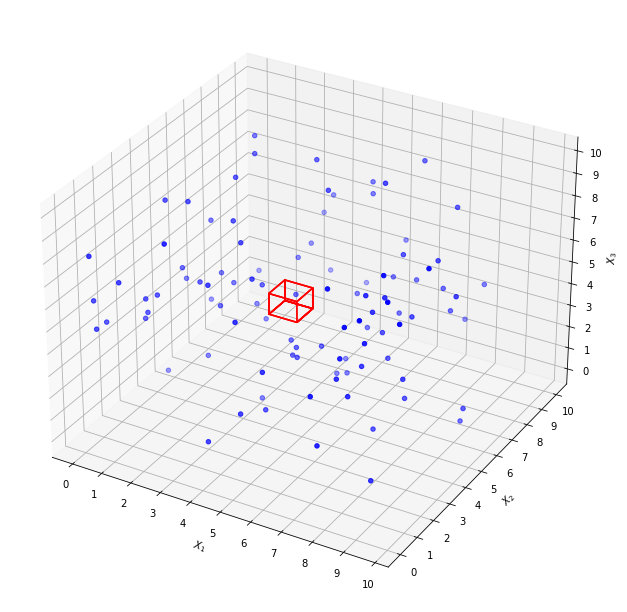

In [16]:
# Visualisiere die Verteilung von x_1 und x_2 und x_3

fig = plt.figure(figsize=(16, 11))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, x3, c="b", marker="o")

ax.plot_wireframe(
    np.array([[1,1], [1,2], [2, 2], [2, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 2], [2, 2], [2, 2]]),
    np.array([[9,10], [10, 10], [10, 9], [9, 9], [9, 9], [9, 10], [10, 10], [10, 9], [9, 9], [9, 9], [9, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 9], [9, 9]]),
    np.array([[0, 0], [0, 0], [0, 0], [0, 0], [0, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 0], [0, 0], [0, 1], [1, 0], [0, 0], [0, 1], [1, 0], [0, 0], [0, 1]]),
    color='r', rstride=1, cstride=1, alpha=0.9
)

ax.set_xticks(np.arange(0, 11, 1) )
ax.set_yticks(np.arange(0, 11, 1) )
ax.set_zticks(np.arange(0, 11, 1) )
ax.grid(color='k', linestyle='-', linewidth=1, alpha=0.6)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_zlabel('$X_3$')

# fig.savefig('ML_0514.png', bbox_inches='tight')

Die statistische Signifikanz der Ergebnisse aller Machine-LearningAlgorithmen hängt sowohl von der Anzahl der Daten, die du analysierst, als auch von der Anzahl der Features ab, die du wählst. Eine unzureichende Anzahl von Daten führt häufig zu Overfitting. Benutzt du zu viele Features, steht durchschnittlich pro Raumeinheit eine zu kleine Anzahl an Stichproben zur Verfügung, sodass signifikante Aussagen nicht mehr möglich sind.

## Overfitting und Underfitting: Model-Komplexität vs Datenmenge

Den Zusammenhang zwischen der Anzahl der Trainingsbeispiele, der Komplexität eines Modells und Overfitting kann man am besten am Beispiel von nicht-linearer Regression zeigen. Dazu generieren wir eine kubische Verteilung (Polynom 3. Grades) mit 20 Datenpunkten (siehe Abbildung 5-4).

In [17]:
# Erzeuge 20 Datenpunkte einer kubischen Kurve (mit Noise)
np.random.RandomState(1)

n_samples = 20
X = np.random.uniform(-2, 2, n_samples)
y = X**3 + np.random.uniform(0, 2, n_samples)

(20,) (20,)


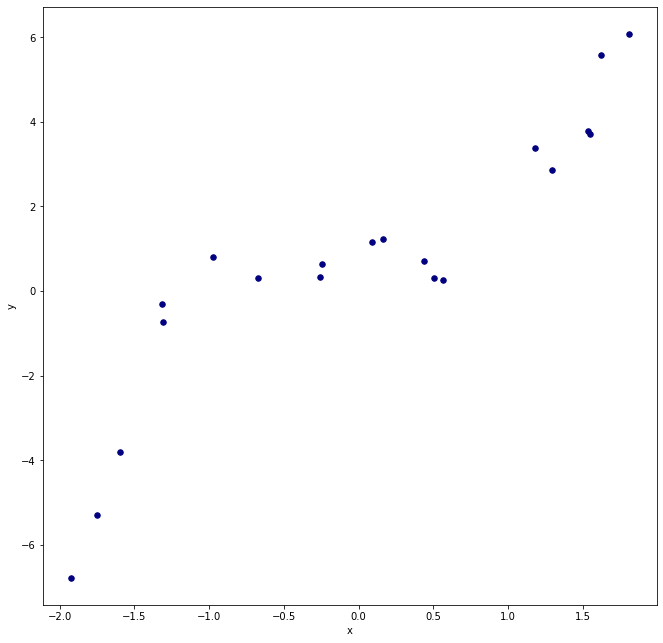

In [18]:
# Visualisiere die Datenpunkte
fig, ax = plt.subplots(figsize=(11, 11))

print(X.shape, y.shape)
plt.scatter(X, y, color='navy', s=30, marker='o')

plt.xlabel('x')
plt.ylabel('y')

# fig.savefig('ML_0504.png', bbox_inches='tight')

Wenn du den Grad des Polynoms bereits vorher weißt, kannst du oft schon mit 20 Datenpunkten ein gutes Modell ohne Overfitting
erhalten, wie du in Abbildung 5-5 sehen kannst.

Text(0, 0.5, 'y')

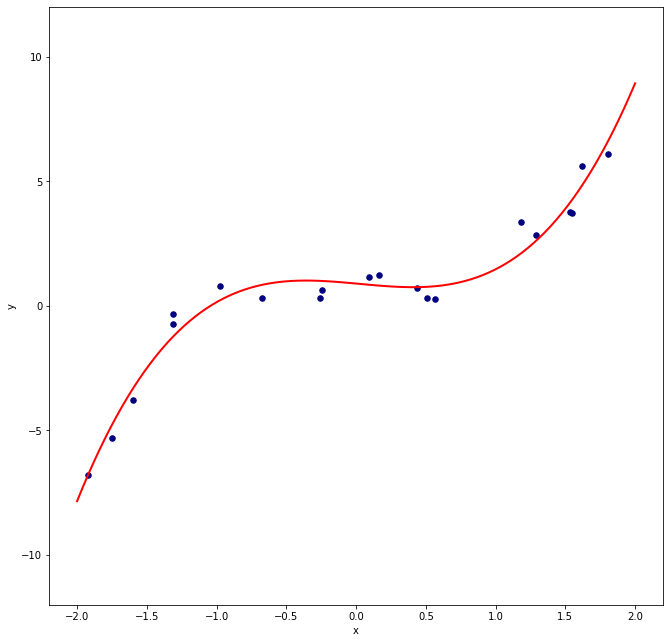

In [26]:
# Trainiere ein Polynom 3. Grades auf den Daten
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures

fig, ax = plt.subplots(figsize=(11, 11))
plt.scatter(X, y, color='navy', s=30, marker='o')

x_plot = np.linspace(-2, 2, 100)
poly_model = make_pipeline(PolynomialFeatures(3),
                           LinearRegression())
poly_model.fit(X.reshape(-1, 1), y)
y_plot = poly_model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, lw=2, color="red")
plt.ylim(-12, 12)

plt.xlabel('x')
plt.ylabel('y')

# fig.savefig('ML_0505.png', bbox_inches='tight')

In der Regel kennen wir die Komplexität unseres Problems aber nicht. Um Underfitting zu vermeiden, wird daher häufig eher ein zu
komplexes Modell gewählt. In unserem Beispiel wäre eine lineare Regression (eine Gerade ist ein Polynom 1. Grades) ein zu simples
Modell. Das erkennst du auch am Ergebnis der linearen Regression in Abbildung 5-6.

Text(0, 0.5, 'y')

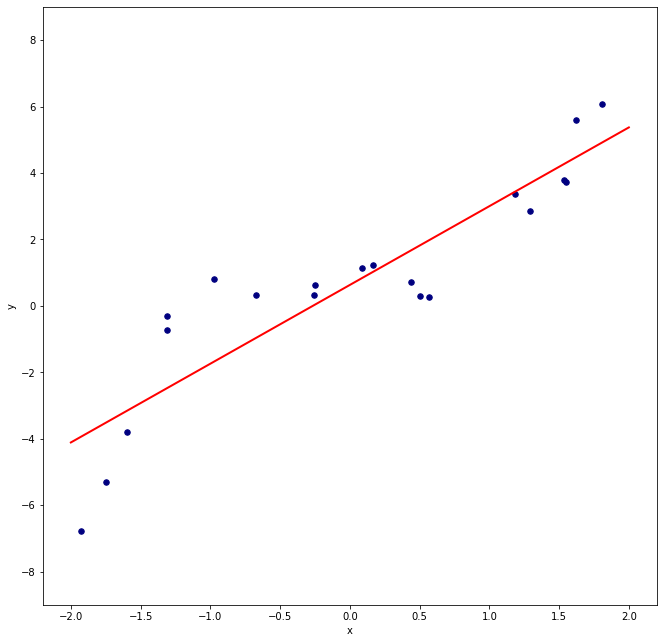

In [27]:
# Trainiere eine einfache lineare Regression auf den Daten
fig, ax = plt.subplots(figsize=(11, 11))
plt.scatter(X, y, color='navy', s=30, marker='o')


model = LinearRegression()
model.fit(X.reshape(-1, 1), y)
y_plot = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, lw=2, color="red")
plt.ylim(-9, 9)

plt.xlabel('x')
plt.ylabel('y')

# fig.savefig('ML_0507.png', bbox_inches='tight')

Ein zu komplexes Modell führt hingegen zu Overfitting. Im Extremfall wird sogar jeder Datenpunkt perfekt vorhergesagt, wenn
wir z.B. ein Polynom 20. Grades zur Regression benutzen, wie in Abbildung 5-7 dargestellt.

Text(0, 0.5, 'y')

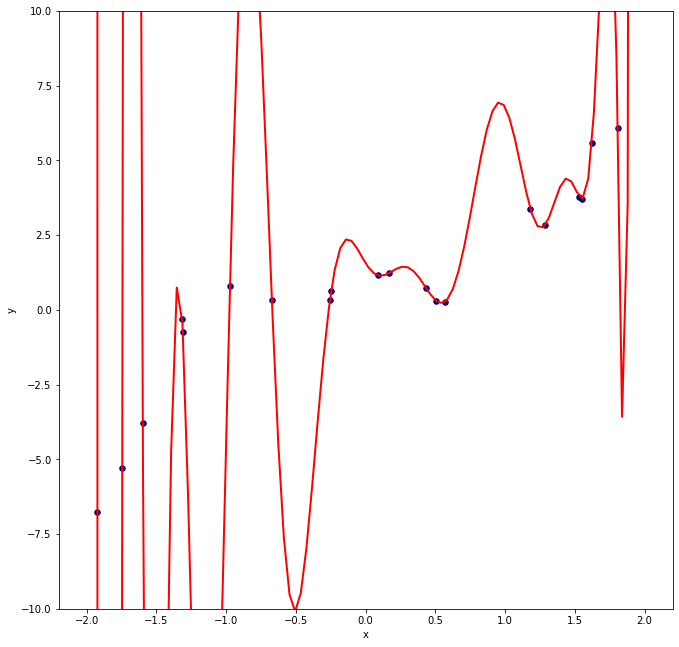

In [29]:
# Trainiere ein Polynom 20. Grades auf den Daten
fig, ax = plt.subplots(figsize=(11, 11))
plt.scatter(X, y, color="navy", s=30, marker="o")

poly_model = make_pipeline(PolynomialFeatures(20), LinearRegression())
poly_model.fit(X.reshape(-1, 1), y)
y_plot = poly_model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, lw=2, color="red")
plt.ylim(-10, 10)

plt.xlabel("x")
plt.ylabel("y")

# fig.savefig('ML_0506.png', bbox_inches='tight')


### Mehr Datensätze

Wenn wir nun statt 20 200 Datenpunkte generieren, erhalten wir bei Regression mit einem Polynom 3. Grades wiederum eine gutes
Modell, wie man in Abbildung 5-8 sehen kann.

In [31]:
# Erzeuge nun 200 Beispiele für die kubische Funktion
n_samples = 200
X = np.random.uniform(-2, 2, n_samples)
y = X**3 + np.random.uniform(0, 2, n_samples)

(200,) (200,)


Text(0, 0.5, 'y')

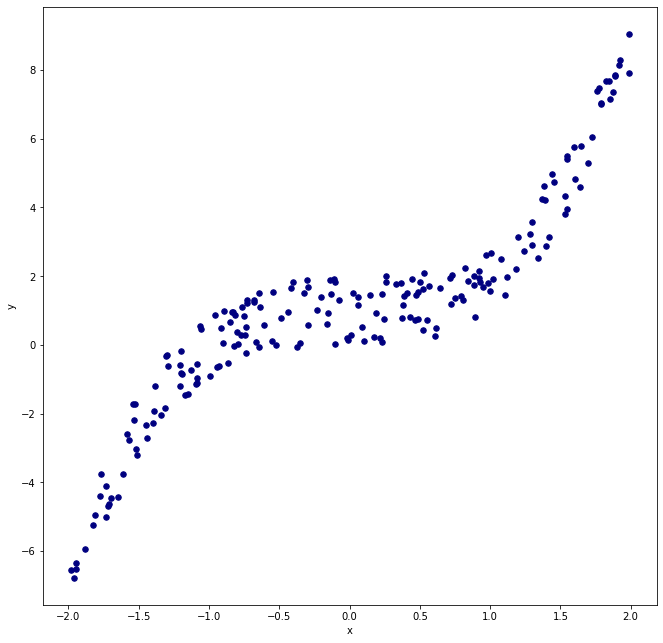

In [33]:
# Visualisiere die Daten
print(X.shape, y.shape)

plt.figure(figsize=(11, 11))
plt.scatter(X, y, color='navy', s=30, marker='o', label="training points")

plt.xlabel('x')
plt.ylabel('y')

# fig.savefig('ML_0508.png', bbox_inches='tight')

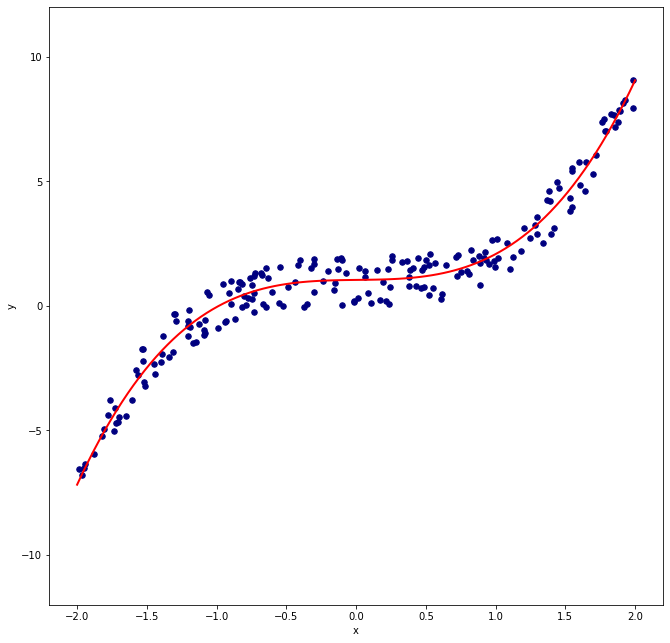

In [36]:
# Trainiere wieder ein Polynom 3. Grades auf den Daten
fig, ax = plt.subplots(figsize=(11, 11))
plt.scatter(X, y, color='navy', s=30, marker='o', label="training points")

poly_model = make_pipeline(PolynomialFeatures(3),
                           LinearRegression())
poly_model.fit(X.reshape(-1, 1), y)
y_plot = poly_model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, lw=2, color="red")
plt.ylim(-12, 12)

plt.xlabel('x')
plt.ylabel('y')

# fig.savefig('ML_0509.png', bbox_inches='tight')
plt.show()
# plt.clf()

Text(0, 0.5, 'y')

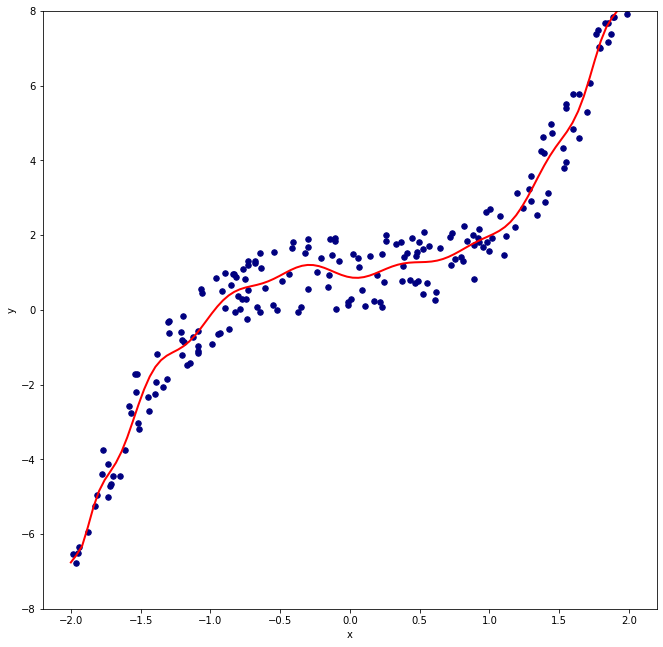

In [37]:
# Trainiere wieder ein Polynom 20. Grades auf den Daten
fig, ax = plt.subplots(figsize=(11, 11))
plt.scatter(X, y, color='navy', s=30, marker='o', label="training points")

poly_model = make_pipeline(PolynomialFeatures(20),
                           LinearRegression())
poly_model.fit(X.reshape(-1, 1), y)
y_plot = poly_model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, lw=2, color="red")
plt.ylim(-8, 8)

plt.xlabel('x')
plt.ylabel('y')

# fig.savefig('ML_0510.png', bbox_inches='tight')

Für viele Probleme gilt in der Regel, dass man mit mehr Daten, weniger Features und geringerer Komplexität des Modells die Wahrscheinlichkeit des Overfittings reduziert.

Im vorigen Kapitel haben wir dir Regularisierungsmethoden für verschiedene Algorithmen gezeigt, mit denen man die Komplexität der Modelle kontrollieren kann. Die Anzahl der Daten ist oft begrenzt. Die Reduzierung der Features ist daher häufig eine gute Option zur Optimierung deiner Ergebnisse. 

In diesem Kapitel werden wir dir einige Techniken zeigen, mit denen man die Anzahl der Features reduzieren kann, ohne dabei wichtige Informationen zu verlieren, bzw. mit denen wir den Informationsverlust minimieren können.

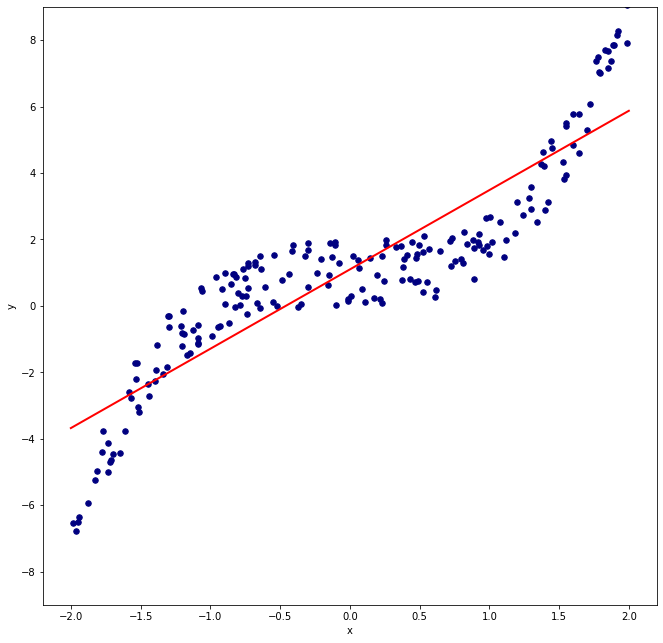

In [38]:
# Trainiere eine simple lineare Regression auf den Daten
# keine Verbesserung auch bei mehr Daten (aber robuster)
fig, ax = plt.subplots(figsize=(11, 11))
plt.scatter(X, y, color='navy', s=30, marker='o', label="training points")

poly_model = make_pipeline(PolynomialFeatures(1),
                           LinearRegression())
poly_model.fit(X[:, np.newaxis], y)
y_plot = poly_model.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, y_plot, lw=2, color="red")
plt.ylim(-9, 9)

plt.xlabel('x')
plt.ylabel('y')

# fig.savefig('ML_0511.png', bbox_inches='tight')
plt.show()
# plt.clf()

## Auswahl der Feature

Im letzten Abschnitt haben wir darüber diskutiert, warum es wichtig ist, nur eine begrenzte Anzahl von Features zu benutzen. In den
Fällen, bei denen es sinnvoll ist, die Anzahl der Features zu reduzieren, stellen sich also diese Fragen:

- Was ist ein gutes Feature?
- Wie viele Features brauchen wir?
- Gibt es eine optimale Kombination an Features?

Die perfekte Feature-Kombination wird man bei vielen komplexeren Problemen nur schwer finden können, aber wir versuchen, dieser so nahe wie möglich zu kommen. Im Folgenden möchten wir dir anhand des Irisbeispiels zeigen, wie man systematisch an diese Fragen herangeht. Wir werden dir einige Methoden zeigen, mit deren Hilfe du abschätzen kannst, welche Features du benutzen und welche du weglassen kannst oder solltest.

Oft ergibt es Sinn, Features erst dann zu reduzieren, wenn sehr viele zur Auswahl stehen. Die obere Grenze hängt meist ab von deinem speziellen Problem, dem verwendeten Algorithmus, den vorhandenen Ressourcen etc. Es kann also schon bei zehn Features beginnen oder erst bei mehreren Hundert.

Der besseren Anschaulichkeit wegen werden wir keinen Datensatz mit vielen Features als Beispiel nehmen, sondern unseren Irisdatensatz mit vier Features. Wir wissen schon, dass alle vier Features informativ sind, d. h., jedes trägt dazu bei, eine bessere Klassifizierung zu erhalten. Zu Demonstrationszwecken werden wir für die Beispiele zusätzliche Features generieren, die entweder nicht informativ oder aus einem der anderen Features abgeleitet (also redundant) sind.

### Univariate Feature Exploration

Am Anfang eines Projekts mit neuen Daten hilft es oft, verschiedene Diagramme zu erstellen. Dadurch erhältst du ein besseres Verständnis von den Daten, d.h. ein besseres Bild über die Zusammenhänge zwischen den verschiedenen potenziellen Features und dem Target. Bei den sogenannten univariaten Diagrammen werden Histogramme der einzelnen Features erstellt.

In unserem Irisdatensatz sind die Längen und Breiten der beiden Blütenblätterarten (setosa, versicolor, virginica) von 150 Irispflanzen aufgelistet: sepal length, sepal width, petal length, petal width. Die entsprechenden vier Histogramme sind in Abbildung
5-10 dargestellt.

In [58]:
# Lade den Iris-Datensatz und erzeuge ein weiteres Noise Feature
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data
y = iris.target
print(X.shape, y.shape)

# Add random noise
rns = np.random.RandomState(12)
noise1 = rns.lognormal(mean=1, size=(len(X), 1))
noise2 = rns.uniform(0, 6, size=(len(X), 1))

#X_noise = np.hstack([X, noise1])
X_noise = np.hstack([X, noise2])

print(X_noise.shape)

(150, 4) (150,)
(150, 5)


In [21]:
# alt
from sklearn.datasets import load_iris
from sklearn.svm import SVC

iris = load_iris()

X = iris.data
y = iris.target
print(X.shape, y.shape)

import numpy as np
import matplotlib.pyplot as plt

svc = SVC(kernel='linear', C=1E0)
print(X.shape, y.shape)

n_classes = 3
colors = 'byr'
CMAP = colors
plot_step = 0.01

# Add random noise
rns = np.random.RandomState(12)
#noise1 = rns.lognormal(mean=1, size=(len(X), 1))
noise2 = rns.uniform(0, 6, size=(len(X), 1))

#X_noise = np.hstack([X, noise1])
X_noise = np.hstack([X, noise2])

(150, 4) (150,)
(150, 4) (150,)


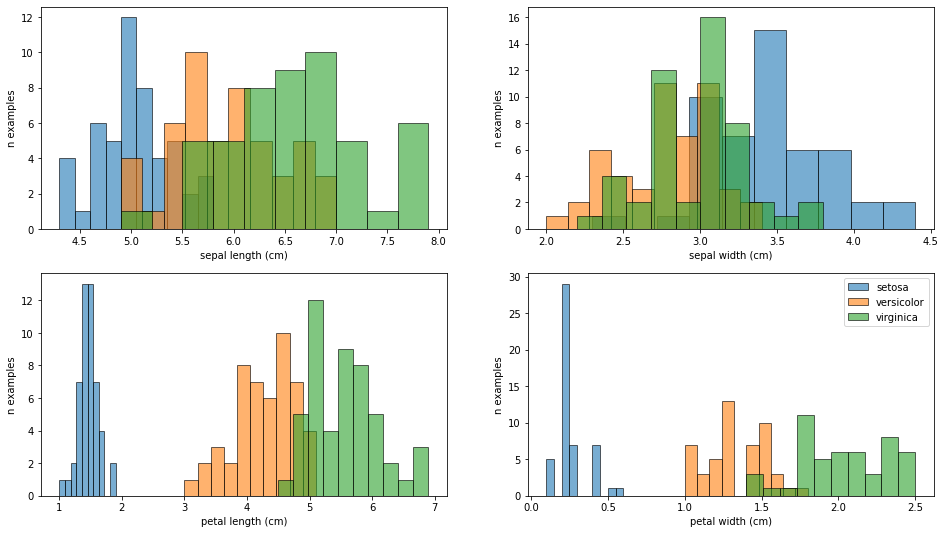

In [74]:
# Visualisiere die Verteilung pro Feature und Klasse
Y_feature_names = iris.feature_names
Y_target_names = iris.target_names

fig = plt.figure(1, figsize=(16, 9))

n_classes = 3
colors = 'byr'
CMAP = colors

for fid in range(4):
    plt.subplot(2, 2, fid + 1)

    plt.xlabel(Y_feature_names[fid])
    plt.ylabel('n examples')
    plt.axis("tight")

    for i, color in zip(range(n_classes), colors):
        idx = np.where(y == i)
        plt.hist(X[idx, fid].flatten(), alpha=0.6, edgecolor='black', lw=1, label=Y_target_names[i])
        if fid==3:
            plt.legend(loc='upper right')

    plt.axis("tight")

# fig.savefig('ML_0501.png', bbox_inches='tight')

Wie du siehst, kann man die Art Iris setosa von den anderen beiden Irisarten sehr leicht mithilfe nur eines Features unterscheiden: entweder über die Petal-Länge oder Petal-Breite. Im folgenden Code wenden wir den linearen SVC für jeweils ein Feature an:

In [78]:
# Wir überprüfen die Vermutung, dass sich setosa von den anderen zwei Klassen mit nur einem Feature trennen lässt
# Trainiere eine SVM jeweils auf einem Feature, wobei wir versicolor und virginica zusammenlegen
from sklearn.datasets import load_iris
import numpy as np
from sklearn.svm import SVC

svc = SVC(kernel='linear')
iris = load_iris()

for fid in range(len(iris.feature_names)):
    X = iris.data[:, fid].reshape(-1, 1)
    y = iris.target
    y[y==2] = 1 # Fassen versicolor und virginica in eine Klasse zusammen
    clf = svc.fit(X, y)
    print(iris.feature_names[fid], "(univariate score):",
    clf.score(X, y))

sepal length (cm) (univariate score): 0.8933333333333333
sepal width (cm) (univariate score): 0.8333333333333334
petal length (cm) (univariate score): 1.0
petal width (cm) (univariate score): 1.0


Mit petal length oder petal width können wir setosa von den beiden anderen Arten perfekt trennen, aber nicht mit sepal length oder sepal width.

Die Arten versicolor und virginica können hingegen sogar mit allen vier Features nicht gut getrennt werden. Das siehst du mithilfe dieses Codes, in dem wir die Arten versicolor und virginica explizit vorher herausfiltern:

In [79]:
iris = load_iris() # reload data
X = iris.data
y = iris.target

ids = y >= 1 # select only versicolor and virginica
clf = svc.fit(X[ids], y[ids])
clf.score(X, y)

0.66

### Bivariate Feature Exploration

#### Varianz und Korrelation

Eine einfache Methode, um die Beziehung zwischen zwei Features oder einem Feature und dem Target zu verstehen, ist die Berechnung des Pearson-Korrelationskoeffizienten $r$, den wir schon kurz bei der Bestimmung von Ausreißern in Kapitel 3, Datenimport und
-vorbereitung, gesehen haben. Er ist folgendermaßen definiert:

$$ r = \cfrac{cov(X,Y)}{std(X) std(Y)} $$

... wobei $cov(X,Y)$ für die Kovarianz zwischen den Features $X$ und $Y$ steht und $std(X)$ für die Standardabweichung von $X$ (die genaue
Definition kannst du auch hier nachschlagen: https://de.wikipedia.org/wiki/Korrelationskoeffizient).

Ein $r$-Wert von 1 bedeutet, dass die beiden Variablen linear 100% korreliert sind, ein Wert von –1, dass sie 100% linear antikorreliert
sind, und ein Wert von 0, dass keine lineare Korrelation besteht. Beispiele für einige Verteilungen mit den zugehörigen  Korrelationskoeffizienten sind in Abbildung 5-11 dargestellt.

![](https://upload.wikimedia.org/wikipedia/commons/0/02/Correlation_examples.png)

( Pearson-Korrelationskoeffizient für verschiedene Verteilungen in der x-y-Ebene (Abbildung aus https://en.wikipedia.org/wiki/Pearson_correlation_coefficient))

Starke Korrelation zwischen zwei Features ist ein Indikator dafür, dass die beiden Features möglicherweise ähnliche Informationen tragen.

In Abbildung 5-12 sind die sechs bivariaten Diagramme des Irisdatensatzes zusammen mit den jeweiligen Korrelationskoeffizienten dargestellt.

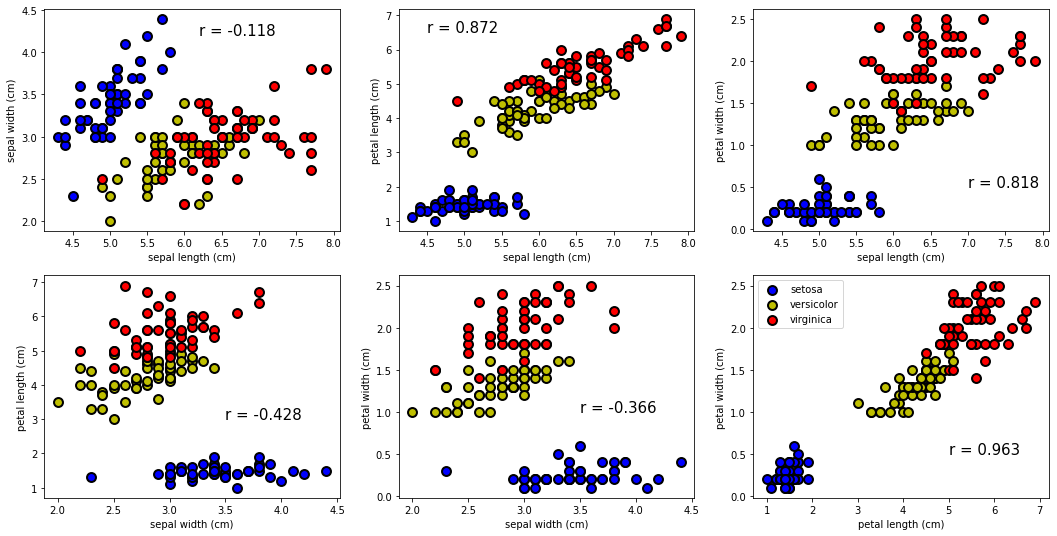

In [82]:
from scipy.stats import pearsonr

Y_feature_names = iris.feature_names

n_classes = 3
colors = "byr"
CMAP = colors
plot_step = 0.01

fig = plt.figure(1, figsize=(18, 9))

pos = [[6.2, 4.2], [4.5, 6.5], [7, 0.5], [3.5, 3], [3.5, 1], [5, 0.5]]

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    plt.subplot(2, 3, pairidx + 1)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    for i, color in zip(range(n_classes), colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            edgecolor="black",
            s=80,
            lw=2,
            label=iris.target_names[i],
            cmap=CMAP,
        )

    r = "r = " + str(round(pearsonr(X[:, 0], X[:, 1])[0], 3))
    plt.text(pos[pairidx][0], pos[pairidx][1], r,  fontdict={"size": 15})
    plt.axis("tight")
    plt.axis("tight")

plt.legend(loc="upper left")

# fig.savefig('ML_0502.png', bbox_inches='tight')

#### Korrelation zwischen Feature und Target

Starke Korrelation zwischen einem Feature und dem Target ist ein Indikator dafür, dass das Feature informativ oder relevant ist. Das bedeutet, dass es wertvolle Informationen besitzt, die ein Algorithmus zur Klassifizierung oder Regression verwenden kann. 

Besteht eine starke lineare Korrelation oder Antikorrelation zwischen Feature und Target-Wert, besitzt das Feature eine hohe Klassifizierungsfähigkeit. In Abbildung 5-10 haben wir bereits gesehen, dass die Irisarten setosa und versicolor perfekt zu trennen sind.
Dementsprechend erwarten wir auch einen hohen Korrelationswert zwischen dem Feature petal length und Target sowie petal width und Target, was wir mit folgendem Code überprüfen:

In [85]:
# Bestimme die Korrelation zwischen feature und target
from sklearn.datasets import load_iris
import numpy as np
from scipy.stats import pearsonr # pearson package from scipy

iris = load_iris() # reload data
X = iris.data
y = iris.target

for fid in (0, 1, 2, 3): # loop over all features
    #idx = np.where( (y == 0) | (y == 1) )
    #x = X[idx]
    x = X[:, fid]
    #print(iris.feature_names[fid], pearsonr(x, y[idx])[0])
    print(iris.feature_names[fid], pearsonr(x, y)[0])

sepal length (cm) 0.7825612318100812
sepal width (cm) -0.426657560781124
petal length (cm) 0.9490346990083889
petal width (cm) 0.9565473328764029


Ein Pearson-Korrelationskoeffizient nahe null heißt nicht zwangsläufig, dass gar keine Beziehung zwischen den beiden Variablen besteht, sondern nur keine lineare, etwa bei einer quadratischen Beziehung

In [86]:
x = np.random.uniform(-1, 1, 1000)
print(pearsonr(x, x**2)[0])

-0.015161847227050752


Dies ist auch einer der größten Nachteile des Pearson-Korrelationskoeffizienten. In Abbildung 5-11 oben siehst du ein paar Beispiele
für verschiedene bivariate Verteilungen und die entsprechenden Pearson-r-Werte. In der untersten Reihe sind einige typische Verteilungen aufgeführt, die einen r-Wert von null besitzen, obwohl eine deutliche Beziehung zwischen x- und z-Wert besteht.

In dieser Beziehung etwas robuster ist die sogenannte Distance Correlation, die du hier nachschlagen kannst: https://en.wikipedia.org/
wiki/Distance_correlation.

Abbildung 5-13 zeigt, dass der Distance-Korrelationskoeffizient bei den meisten Problemfällen einen von null verschiedenen Wert besitzt.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Distance_Correlation_Examples.svg/1920px-Distance_Correlation_Examples.svg.png)

## Principal Component Analyse

Bei der Principal-Component-Analyse (PCA) benutzt man die Varianz der Daten als Kriterium zur Sortierung der Features. Die Idee dabei ist, die Koordinatenachse im Feature-Raum mit der größten Varianz zu finden. Die weiteren Achsen werden nach abnehmender Varianz sortiert mit der Einschränkung, dass alle Achsen orthogonal zueinander sein müssen. Auf diese Weise erhält man ein ganz neues Koordinatensystem und damit einen ganz neuen Feature-Raum.

Abbildung 5-14 zeigt eine zweidimensionale Verteilung zweier zufälliger Features $x_1$ und $x_2$. Eingezeichnet sind auch die berechneten PCA-Komponenten, skaliert mit der jeweiligen Varianz.

Transformiert man die Daten in den neuen Raum, der von den beiden PCA-Komponenten aufgespannt wird, erhält man das in Abbildung 5-15 Dargestellte.

In [87]:
import numpy as np
import matplotlib.pyplot as plt

rns = np.random.RandomState(12)

size = 200
X = np.zeros((size, 2))
x1 = rns.uniform(0, 2, size=size)
x2 = -1.1*x1+1.8 + rns.normal(0, 0.2, size=size)
X[:, 0] = x1
X[:, 1] = x2

from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca.fit(X)

print(pca.explained_variance_)
print()
print(pca.components_)
print()
print(pca.mean_)
print()

[0.81109522 0.0167764 ]

[[-0.64570541  0.76358662]
 [-0.76358662 -0.64570541]]

[1.0178832 0.6643377]



[-0.64570541  0.76358662]
[-0.76358662 -0.64570541]


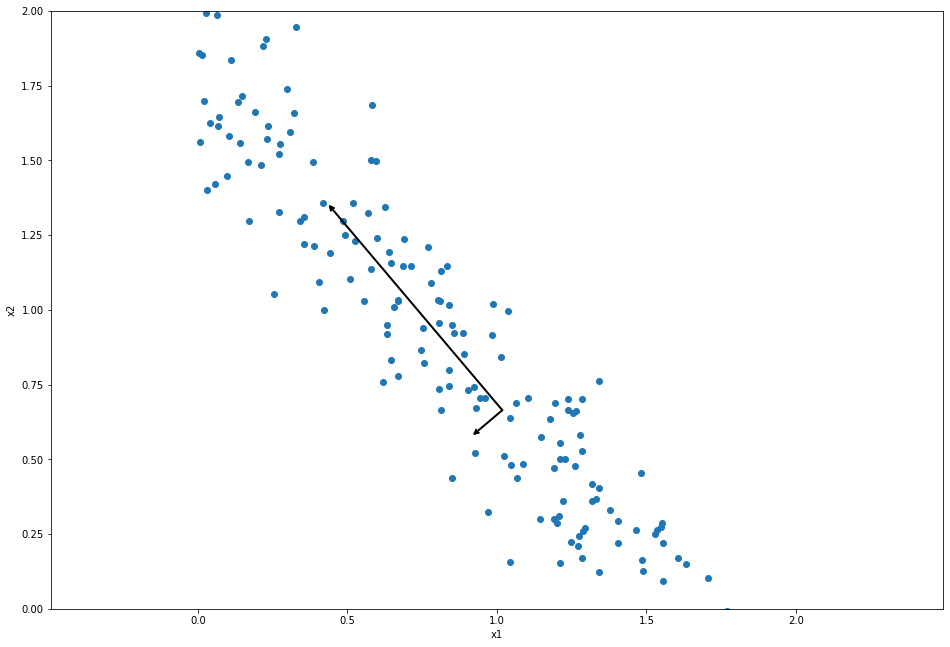

In [27]:
fig = plt.figure(figsize=(16, 11))

plt.scatter(X[:, 0], X[:, 1])
arrowprops = dict(arrowstyle='->',
                  linewidth=2, shrinkA=0, shrinkB=0)
for length, vector in zip(pca.explained_variance_, pca.components_):
    print(vector)
    v = vector * 1 * np.sqrt(length)
    ax = plt.gca()
    ax.annotate('', pca.mean_ + v, pca.mean_, arrowprops=arrowprops)

plt.axis('equal')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('x1')
plt.ylabel('x2')

# fig.savefig('ML_0515.png', bbox_inches='tight')
plt.show()
# plt.clf()

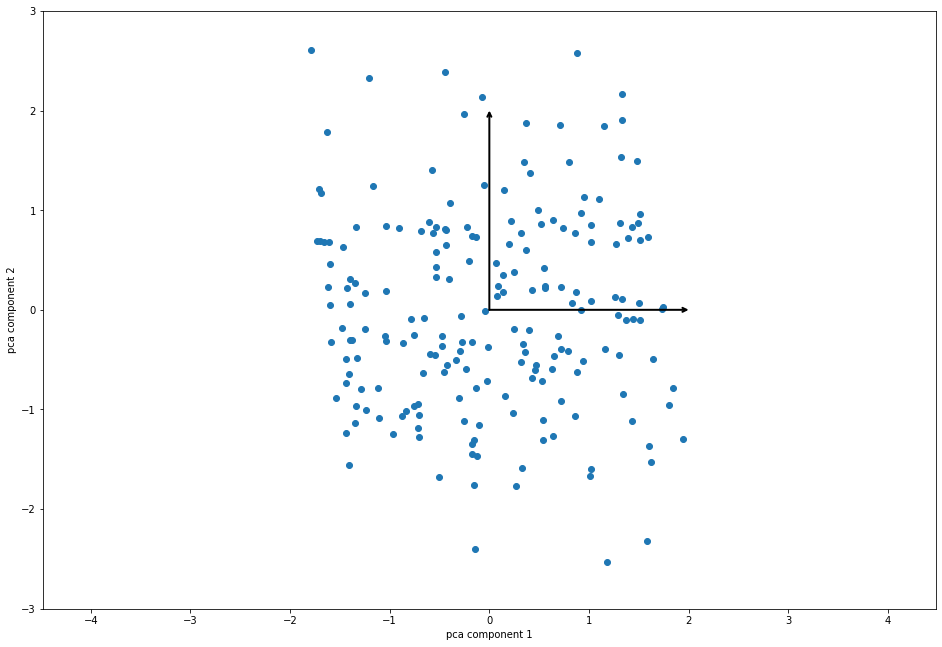

In [28]:
fig = plt.figure(figsize=(16, 11))

X_pca = pca.transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1])

plt.annotate('', [0, 2], [0, 0], arrowprops=arrowprops)
plt.annotate('', [2, 0], [0, 0], arrowprops=arrowprops)

plt.axis('equal')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')

# fig.savefig('ML_0516.png', bbox_inches='tight')
plt.show()
# plt.clf()

PCA wird häufig bei der Datenexploration und -visualisierung benutzt, weil man hochdimensionale Daten in zwei- oder dreidimensionale Daten mit möglichst geringem Informationsverlust transformieren kann. Dadurch kann man z.B. visuell untersuchen, ob sich die Daten in bestimmten Bereichen clustern.

Beispielsweise können wir die vier Feature-Dimensionen des Irisdatensatzes mithilfe von PCA auf zwei Dimensionen reduzieren, visualisiert in Abbildung 5-16.

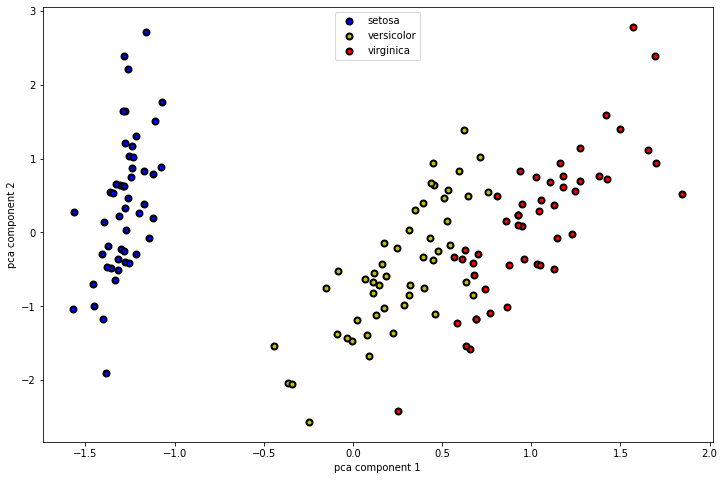

In [88]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

n_classes = 3
colors = 'byr'
CMAP = colors

iris = load_iris()

X = iris.data
y = iris.target

Y_target_names = iris.target_names


pca = PCA(n_components=2, whiten=True)
pca.fit(X)

#_________________________________________________________
fig = plt.figure(figsize=(12, 8))

X_pca = pca.transform(X)

for i, color in zip(range(n_classes), colors):
    idx = np.where(y == i)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label = Y_target_names[i],  c=color,
                edgecolor='black', lw=2, cmap=CMAP)

plt.axis("tight")
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.legend(loc='upper center')

# fig.savefig('ML_0519.png', bbox_inches='tight')

## Featureselektion

Es gibt verschiedene Strategien zur Reduzierung der Input-Features. Bei den meisten Methoden wird jeweils eine Rangliste der Features
aufgestellt, die für das gegebene Problem den vermeintlich höchsten Informationsgehalt besitzen. Drei der gängigsten Techniken stellen
wir dir in diesem Abschnitt vor.

In [102]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target

# reference score
svc = SVC(kernel='linear', C=1)
clf = svc.fit(X, y)
print(clf.score(X, y))

0.9933333333333333


In [101]:
# Add random noise as non informative data
rns = np.random.RandomState(12)
noise = rns.uniform(0, 6, size=(len(X), 1))
X = np.hstack([X, noise])

# Score with all noise
clf = svc.fit(X, y)
print(clf.score(X, y))

0.9933333333333333


In [103]:
rns = np.random.RandomState(12)
noise = rns.uniform(0, 6, size=(len(X), 5))
X = np.hstack([X, noise])

# Score with all noise
clf = svc.fit(X, y)
print(clf.score(X, y))

0.9866666666666667


In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=4)
X_sel = selector.fit_transform(X, y)

In [33]:
print(selector.scores_)

[1.19264502e+02 4.91600401e+01 1.18016118e+03 9.60007147e+02
 9.48960689e-01]


In [34]:
svc = SVC(kernel='linear', C=1)
clf = svc.fit(X_sel, y)
print(clf.score(X_sel, y))

0.9933333333333333


## Selektion nach Tree-Modellen

In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X, y)
print(clf.feature_importances_)

[0.12635013 0.05162818 0.42587259 0.37392282 0.02222628]


In [36]:
selector = SelectFromModel(clf, threshold=0.02)
X_sel = selector.fit_transform(X, y)
print(selector.get_support())

[ True  True  True  True  True]


In [37]:
svc = SVC(kernel='linear')
clf = svc.fit(X_sel, y)
print(clf.score(X_sel, y))

0.9933333333333333


## Rekursive Eliminierung nach Modellen

In [38]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=12)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [39]:
from sklearn.feature_selection import RFE
selector = RFE(clf, 4)

In [40]:
selector = selector.fit(X, y)

In [41]:
print(selector.get_support())

[ True  True  True  True False]
